<a href="https://colab.research.google.com/github/ucbahallaou/reviews_topic_modeling_w266_project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redefining Customer Satisfaction: A Novel Approach to Aspect-Based Sentiment Analysis

**Description:** This project analyzes customer reviews in a resource-limited environment using different topic modeling and sentiment analysis models to extract meaningful themes and sentiments. The analysis spans across traditional models like LDA and BERTopic, and state-of-the-art models like GPT-4.

## Notebook Contents

- **1. Imports and Ingesting Data**  
  In this section we import all of the necessary libraries for the study and load in data via the Kaggle API. A Json file containing the credentials of a users Kaggle must be used to load the dataset.

- **2. Data Preprocessing and Exploration**  
  After the data is ingested into the notebook, we apply preprocessing techniques on each review such as formatting, tokenization and lemmatization. The tokenized words are put through n-grams to see what words are common in each sentiment.

- **3. Exploring the LDA Model**  
  After the data is processed and cleaned, we develop the LDA Model and do hyperparameter tuning and tested to find the most optimal model.

- **4. BERTopic**  
  Following the LDA, we apply BERTopic to the data as a comparison to the LDA approach, and we categorize each review into the topics.

- **5. Sentiment Analysis using DistilBERT and alBERTa**  
  Finally, a small subset of the data is trained and tested using the DistilBERT architecture to see how well it can predict the sentiments of the reviews passed.

---

[Return to Top](#)


### 1. Imports and Ingesting Data

Lets get all our libraries and download and process our data.

In [ ]:
!pip install kaggle transformers torch datasets scikit-learn bertopic pyLDAvis

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#files and apis
import numpy as np
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from io import BytesIO
from zipfile import ZipFile

import pandas as pd
import matplotlib.pyplot as plt

#import preprocessing libraries
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
import string

#nlp libraries
import torch
from transformers import AlbertForSequenceClassification, AlbertTokenizer, BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, DistilBertForSequenceClassification, DistilBertTokenizer, AutoTokenizer, AutoModelForSequenceClassification
import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import train_test_split
from gensim.corpora.dictionary import Dictionary
from datasets import Dataset
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
sentiment_words = set([
    'good', 'great', 'excellent', 'bad', 'poor', 'terrible', 'awesome',
    'horrible', 'positive', 'negative', 'love', 'hate', 'dislike', 'like', 'nice', 'amazing'
])
lemmatizer = WordNetLemmatizer()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def download_and_load_kaggle_dataset(dataset_name, file_name):
    """
    Downloads a dataset from Kaggle and loads it into a pandas DataFrame.

    :param dataset_name: The name of the Kaggle dataset (e.g., 'karan2002shah/topic-analysis-of-review-data')
    :param file_name: The name of the file within the dataset to load (e.g., 'K8 Reviews v0.2.csv')
    :return: A pandas DataFrame containing the dataset
    """
    api = KaggleApi()
    api.authenticate()

    api.dataset_download_files(dataset_name, path='kaggle_data', unzip=True)

    file_path = os.path.join('kaggle_data', file_name)
    return pd.read_csv(file_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dataset_name = 'karan2002shah/topic-analysis-of-review-data'
file_name = 'K8 Reviews v0.2.csv'
df = download_and_load_kaggle_dataset(dataset_name, file_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset URL: https://www.kaggle.com/datasets/karan2002shah/topic-analysis-of-review-data


/usr/local/lib/python3.10/dist-packages/kaggle/api_client.py:165: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.
  response_data.getheaders())


In [ ]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...
...,...,...
14670,1,"I really like the phone, Everything is working..."
14671,1,The Lenovo K8 Note is awesome. It takes best p...
14672,1,Awesome Gaget.. @ this price
14673,1,This phone is nice processing will be successf...


###2. Data Preprocessing and Exploration
  After the data is ingested into the notebook, we apply preprocessing techniques on each review such as formatting, tokenization and lemmatization. The tokenized words are put through n-grams to see what words are common in each sentiment.

In [ ]:
def generate_ngrams(tokens, n_grams):
    three_grams = ngrams(tokens, n_grams)
    return [' '.join(gram) for gram in three_grams]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Number of Rows:', df.shape[0])
print('Number of Positive Reviews:', df['sentiment'].value_counts()[1])
print('Number of Negative Reviews:', df['sentiment'].value_counts()[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of Rows: 14675
Number of Positive Reviews: 6963
Number of Negative Reviews: 7712


In [ ]:
#lets take a look at some examples of the reviews and their sentiments
print(f"text: {df['review'][0]} \n sentiment: {df['sentiment'][0]}")
print(f"text: {df['review'][1]} \n sentiment: {df['sentiment'][1]}")
print(f"text: {df['review'][2]} \n sentiment: {df['sentiment'][2]}")
print(f"text: {df['review'][3]} \n sentiment: {df['sentiment'][3]}")

text: Good but need updates and improvements 
 sentiment: 1
text: Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with internet uses, even if I put mobile idle its getting discharged.This is biggest lie from Amazon & Lenove which is not at all expected, they are making full by saying that battery is 4000MAH & booster charger is fake, it takes at least 4 to 5 hours to be fully charged.Don't know how Lenovo will survive by making full of us.Please don;t go for this else you will regret like me. 
 sentiment: 0
text: when I will get my 10% cash back.... its already 15 January.. 
 sentiment: 1
text: Good 
 sentiment: 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# lets preprocess some of the text and see some common words being used in each sentiment (using ngrams to see common text)
df['preprocessing text'] = df['review'].apply(preprocess_text)
pos_reviews = df[df['sentiment'] == 1]
neg_reviews = df[df['sentiment'] == 0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
neg_3_n_grams = neg_reviews.apply(lambda x: generate_ngrams(x['preprocessing text'], 3), axis=1).explode()
pos_3_n_grams = pos_reviews.apply(lambda x: generate_ngrams(x['preprocessing text'], 3), axis=1).explode()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dict(neg_3_n_grams.value_counts())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'lenovo k note': 377,
 'dont buy phone': 101,
 'battery drain fast': 88,
 'please dont buy': 84,
 'worst phone ever': 70,
 'battery draining fast': 53,
 'dont buy product': 50,
 'battery backup good': 42,
 'camera quality good': 40,
 'pls dont buy': 32,
 'dont buy lenovo': 32,
 'camera quality poor': 32,
 'dont buy mobile': 29,
 'waste waste waste': 26,
 'battery backup poor': 26,
 'take hour charge': 25,
 'good battery backup': 25,
 'k note k': 23,
 'battery drain quickly': 23,
 'phone dont buy': 23,
 'take much time': 23,
 'lenovo service center': 22,
 'moto g plus': 22,
 'vibe k note': 21,
 'phone get heated': 21,
 'heating issue battery': 21,
 'hour full charge': 21,
 'k note phone': 20,
 'one speaker working': 19,
 'using lenovo k': 19,
 'poor battery backup': 19,
 'dont waste money': 19,
 'gb ram gb': 19,
 'buy lenovo k': 18,
 'k note mobile': 18,
 'call recording option': 18,
 'bought lenovo k': 18,
 'poor camera quality': 18,
 'battery backup bad': 18,
 'plz dont buy': 17,
 't

In [ ]:
dict(pos_3_n_grams.value_counts())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'lenovo k note': 137,
 'battery backup good': 47,
 'good battery backup': 44,
 'phone price range': 41,
 'camera quality good': 33,
 'best phone price': 30,
 'good camera quality': 29,
 'good battery life': 27,
 'good phone price': 22,
 'deca core processor': 21,
 'nice phone good': 20,
 'overall good phone': 20,
 'best phone ever': 19,
 'battery life good': 19,
 'camera good battery': 17,
 'k note good': 17,
 'phone good battery': 16,
 'good phone good': 16,
 'nice phone price': 15,
 'better redmi note': 15,
 'sound quality good': 14,
 'good sound quality': 14,
 'phone battery backup': 13,
 'one best phone': 13,
 'good mobile phone': 13,
 'phone camera quality': 12,
 'phone good camera': 12,
 'best mobile price': 12,
 'good heating issue': 12,
 'phone value money': 12,
 'really good phone': 12,
 'gb ram gb': 12,
 'good product price': 11,
 'dual camera setup': 11,
 'battery backup also': 11,
 'best phone range': 11,
 'good budget phone': 11,
 'good product lenovo': 11,
 'front camera

In [ ]:
top_10_neg_ngram_df = neg_3_n_grams.value_counts()[:10].reset_index().rename(columns={'index':'ngram'})
top_10_pos_ngram_df = pos_3_n_grams.value_counts()[:10].reset_index().rename(columns={'index':'ngram'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_10_neg_ngram_df['Sentiment'] = 'Negative'
top_10_pos_ngram_df['Sentiment'] = 'Positive'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(top_10_pos_ngram_df.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
ngram & count & Sentiment \\
\midrule
lenovo k note & 137 & Positive \\
battery backup good & 47 & Positive \\
good battery backup & 44 & Positive \\
phone price range & 41 & Positive \\
camera quality good & 33 & Positive \\
best phone price & 30 & Positive \\
good camera quality & 29 & Positive \\
good battery life & 27 & Positive \\
good phone price & 22 & Positive \\
deca core processor & 21 & Positive \\
\bottomrule
\end{tabular}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(top_10_neg_ngram_df.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
ngram & count & Sentiment \\
\midrule
lenovo k note & 377 & Negative \\
dont buy phone & 101 & Negative \\
battery drain fast & 88 & Negative \\
please dont buy & 84 & Negative \\
worst phone ever & 70 & Negative \\
battery draining fast & 53 & Negative \\
dont buy product & 50 & Negative \\
battery backup good & 42 & Negative \\
camera quality good & 40 & Negative \\
pls dont buy & 32 & Negative \\
\bottomrule
\end{tabular}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###3. Exploring the LDA Model  
  After the data is processed and cleaned, we develop the LDA Model and do hyperparameter tuning and tested to find the most optimal model.



In [ ]:
review_list = df['review'].to_list()
tokenized_reviews = [word_tokenize(review) for review in review_list]
pos_tagged_reviews = [pos_tag(tokens) for tokens in tokenized_reviews]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#what do the taggings look like for the parts of speech?
print(pos_tagged_reviews[0])

We will test different preprocessing techniques like POS tagging and lemmatization.

In [ ]:
def filter_nouns(tagged_tokens):
    return [word for word, pos in tagged_tokens if pos.startswith('NN')]
noun_only_reviews = [filter_nouns(tagged_review) for tagged_review in pos_tagged_reviews]
lemmatized_reviews = [[lemmatizer.lemmatize(token) for token in review] for review in noun_only_reviews]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(lemmatized_reviews[0])

In [ ]:
def remove_stopwords_and_punctuation(tokens):
    return [token for token in tokens if token not in stop_words and token not in punctuation]

cleaned_reviews = [remove_stopwords_and_punctuation(review) for review in lemmatized_reviews]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(cleaned_reviews[0])

Testing what the output of an LDA model looks like.

In [ ]:
dictionary = corpora.Dictionary(cleaned_reviews)
corpus = [dictionary.doc2bow(review) for review in cleaned_reviews]

lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic: 0 
Words: 0.044*"screen" + 0.040*"call" + 0.028*"speaker" + 0.027*"option" + 0.019*"app" + 0.018*"music" + 0.014*"feature" + 0.013*"Dolby" + 0.013*"Bluetooth" + 0.011*"video"

Topic: 1 
Words: 0.189*".." + 0.064*"problem" + 0.057*"mobile" + 0.025*"hai" + 0.022*"h" + 0.017*"heating" + 0.011*"ho" + 0.009*"box" + 0.008*"Thanks" + 0.008*"buy"

Topic: 2 
Words: 0.179*"product" + 0.067*"Nice" + 0.051*"money" + 0.051*"Amazon" + 0.042*"service" + 0.022*"mobile" + 0.019*"Worst" + 0.017*"customer" + 0.017*"waste" + 0.016*"replacement"

Topic: 3 
Words: 0.045*"delivery" + 0.018*"NOT" + 0.014*"IS" + 0.012*"PHONE" + 0.011*"help" + 0.010*"IT" + 0.010*"thanks" + 0.010*"AND" + 0.010*"MOBILE" + 0.010*"BATTERY"

Topic: 4 
Words: 0.073*"Phone" + 0.031*"Poor" + 0.030*"Bad" + 0.024*"Everything" + 0.023*"budget" + 0.019*"glass" + 0.016*"Network" + 0.015*"item" + 0.013*"version" + 0.012*"system"

Topic: 5 
Words: 0.398*"phone" + 0.025*"issue" + 0.018*"month" + 0.018*"price" + 0.017*"problem" + 0.014*"

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

Taking a look at how the number of topics impact the coherence scores in the LDA model.

In [ ]:
# lets try messing with the number of topics and see how that impacts the coherence score. We can look find the one with the best coherence score and use that as our optimal model
coherence_scores = []
for num_topics in range(4, 15):
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_reviews, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append((num_topics, coherence_lda))

# Print the number of topics with the highest coherence score
best_num_topics = max(coherence_scores, key=lambda x: x[1])[0]
print(f'Best number of topics: {best_num_topics}')

# Train the LDA model with the best number of topics
lda_model = gensim.models.LdaModel(corpus, num_topics=best_num_topics, id2word=dictionary, passes=15)
coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Improved Coherence Score: {coherence_lda}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best number of topics: 7
Improved Coherence Score: 0.49135827568223867


In [ ]:
dictionary = corpora.Dictionary(cleaned_reviews)
corpus = [dictionary.doc2bow(review) for review in cleaned_reviews]

lda_model = gensim.models.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=15)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'cleaned_reviews' is not defined

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


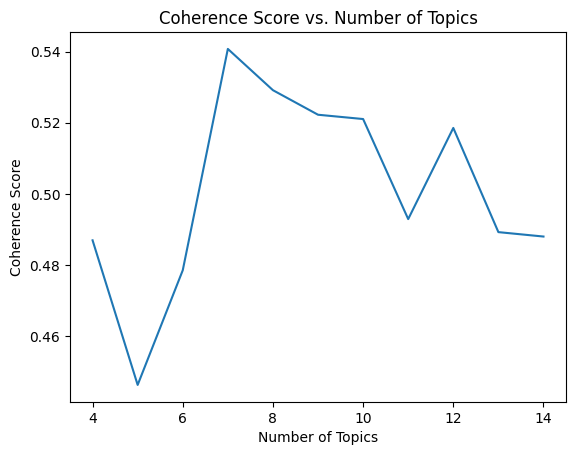

In [ ]:
# Extract number of topics and coherence scores
num_topics_list, coherence_values = zip(*coherence_scores)

# Plot the coherence scores
plt.plot(num_topics_list, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()


Grid Search to find the best hyperparameters for the model.

In [ ]:
alpha_values = [0.01, 0.1, 1, 10]
beta_values = [0.01, 0.1, 1, 10]

def train_lda_with_params(alpha, beta, num_topics=6):
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary,
                                       alpha=alpha, eta=beta, passes=15)
    coherence_model = CoherenceModel(model=lda_model, texts=cleaned_reviews, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Grid search for the best alpha and beta values
best_coherence = 0
best_params = (None, None)
for alpha in alpha_values:
    for beta in beta_values:
        coherence_score = train_lda_with_params(alpha, beta)
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_params = (alpha, beta)
        print(f'Alpha: {alpha}, Beta: {beta}, Coherence Score: {coherence_score}')

print(f'Best Alpha: {best_params[0]}, Best Beta: {best_params[1]}, Best Coherence Score: {best_coherence}')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Alpha: 0.01, Beta: 0.01, Coherence Score: 0.5982965713410507
Alpha: 0.01, Beta: 0.1, Coherence Score: 0.5513293048595987
Alpha: 0.01, Beta: 1, Coherence Score: 0.5939541209107495
Alpha: 0.01, Beta: 10, Coherence Score: 0.6411761706683236
Alpha: 0.1, Beta: 0.01, Coherence Score: 0.5375769537059799
Alpha: 0.1, Beta: 0.1, Coherence Score: 0.5380610742229283
Alpha: 0.1, Beta: 1, Coherence Score: 0.6418156490494963
Alpha: 0.1, Beta: 10, Coherence Score: 0.6739629934362864
Alpha: 1, Beta: 0.01, Coherence Score: 0.5484736056019163
Alpha: 1, Beta: 0.1, Coherence Score: 0.5652258235279167
Alpha: 1, Beta: 1, Coherence Score: 0.5055503238717752
Alpha: 1, Beta: 10, Coherence Score: 0.6686121585548911
Alpha: 10, Beta: 0.01, Coherence Score: 0.5718796367550575
Alpha: 10, Beta: 0.1, Coherence Score: 0.5802835284501803
Alpha: 10, Beta: 1, Coherence Score: 0.5730352427268973
Alpha: 10, Beta: 10, Coherence Score: 0.5486685403316351
Best Alpha: 0.1, Best Beta: 10, Best Coherence Score: 0.6739629934362864

In [ ]:
dictionary = corpora.Dictionary(cleaned_reviews)
corpus = [dictionary.doc2bow(review) for review in cleaned_reviews]

lda_model = gensim.models.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=15)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

In [ ]:
lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=dictionary,
                                       alpha=0.03, eta=0.8, passes=10)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

In [ ]:
neg_reviews

In [ ]:
cleaned_reviews = [preprocess_text(review) for review in df['review'].tolist()]

Visualizing the LDA topics and the words associated with them

In [ ]:
dictionary = corpora.Dictionary(cleaned_reviews)
corpus = [dictionary.doc2bow(review) for review in cleaned_reviews]

num_topics = 10
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=12, alpha= 0.02, eta=0.05)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

lda_vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis_data)

In [ ]:
topics = lda_model.show_topics(num_words=10, formatted=False)

In [ ]:
filtered_topics = {}
for idx, topic in topics:
    terms = [term for term, _ in topic]
    if "phone" in terms or "battery" in terms:  # Example filter condition
        filtered_topics[idx] = terms

# Display filtered topics
for idx, terms in filtered_topics.items():
    print(f"Topic {idx}: {terms}")

In [ ]:
topics

In [ ]:
reviews_list = df['preprocessing text'].to_list()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dictionary = corpora.Dictionary(reviews_list)
dictionary.filter_extremes(no_below=10, no_above=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
review_corpus =[dictionary.doc2bow(review) for review in reviews_list]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Here we create our best LDA model with a minimum probability of a words occurence being 0.01.

In [ ]:
lda_model = models.LdaModel(review_corpus, num_topics=12, id2word=dictionary, passes=12,
                     alpha='auto', eta='auto', minimum_probability=0.01)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def compute_coherence(model, corpus, texts, dictionary):
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
compute_coherence(lda_model, review_corpus, reviews_list, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5976382041853463

In [ ]:
def get_top_n_topics(topic_dist, n=3):
    return sorted(topic_dist, key=lambda x: x[1], reverse=True)[:n]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Assigning the topics that fall into each review based on the LDA model

In [ ]:
df['Top_Topics'] = [get_top_n_topics(dist) for dist in lda_model[review_corpus]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentiment,review,preprocessing text,Top_Topics
0,1,Good but need updates and improvements,"[good, need, update, improvement]","[(5, 0.34259433), (1, 0.2156593), (9, 0.176833..."
1,0,"Worst mobile i have bought ever, Battery is dr...","[worst, mobile, bought, ever, battery, drainin...","[(3, 0.37668756), (11, 0.3029234), (9, 0.21371..."
2,1,when I will get my 10% cash back.... its alrea...,"[get, cash, back, already, january]","[(4, 0.47721797), (9, 0.17228308), (1, 0.06134..."
3,1,Good,[good],"[(1, 0.40686628), (11, 0.088051446), (3, 0.071..."
4,0,The worst phone everThey have changed the last...,"[worst, phone, everthey, changed, last, phone,...","[(11, 0.6660963), (10, 0.11206567), (2, 0.1046..."
...,...,...,...,...
14670,1,"I really like the phone, Everything is working...","[really, like, phone, everything, working, fin...","[(1, 0.35754666), (9, 0.18991496), (7, 0.18031..."
14671,1,The Lenovo K8 Note is awesome. It takes best p...,"[lenovo, k, note, awesome, take, best, picture...","[(5, 0.42360246), (1, 0.12997632), (9, 0.12985..."
14672,1,Awesome Gaget.. @ this price,"[awesome, gaget, price]","[(8, 0.4983302), (1, 0.08906088), (11, 0.06816..."
14673,1,This phone is nice processing will be successf...,"[phone, nice, processing, successful, dual, ca...","[(5, 0.3984337), (7, 0.22577348), (9, 0.140820..."


In [ ]:
lda_model.eta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array([0.14285715, 0.14285715, 0.14285715, ..., 0.14285715, 0.14285715,
       0.14285715], dtype=float32)

In [ ]:
lda_vis_data = gensimvis.prepare(lda_model, review_corpus, dictionary)
pyLDAvis.display(lda_vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Creating a table to display the top words for each topic in the LDA

In [ ]:
def get_top_words_for_topics(lda_model, num_words=6):
    topics = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=num_words, formatted=False)
    topic_words = {}
    for idx, topic in topics:
        words = [word for word, prob in topic]
        topic_words[f"Topic {idx}"] = words
    return topic_words

topic_words = get_top_words_for_topics(lda_model)

topic_df = pd.DataFrame(topic_words)

topic_df.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#f2f2f2'), ('color', 'black')]}]
).set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'border-color': 'black',
    'border-width': '1px',
    'border-style': 'solid'
})


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11
0,nice,day,waste,product,phone,awesome,working,k,problem,good,mobile,price
1,battery,even,dont,amazon,worst,gb,call,lenovo,heating,phone,bad,best
2,charging,phone,money,return,buy,processor,network,note,issue,camera,ok,buy
3,fast,using,handset,received,update,ram,screen,better,money,battery,hai,phone
4,phone,use,please,delivery,lenovo,super,sim,android,phone,quality,superb,range
5,charge,screen,replacement,got,dont,bit,work,feature,worth,performance,h,dont


In [ ]:
def filter_reviews_by_topics(df, topic1, topic2):
    """
    Filters reviews where the top 2 topics are the specified topic numbers.

    Args:
    df (DataFrame): The dataframe containing reviews and their top topics.
    topic1 (int): The first topic number to filter by.
    topic2 (int): The second topic number to filter by.

    Returns:
    DataFrame: A dataframe with reviews matching the criteria.
    """
    filtered_reviews = df[
        df['Top_Topics'].apply(lambda x: len(x) >= 2 and
                               ((x[0][0] == topic1 and x[1][0] == topic2) or
                                (x[0][0] == topic2 and x[1][0] == topic1)))
    ]
    return filtered_reviews

filtered_df = filter_reviews_by_topics(df, 3, 4)
print(filtered_df[['review', 'Top_Topics']])

                                                  review  \
211                  The worst products i have ever buy.   
297    I had purchased on 08/10/2017 after using more...   
320    Lots of issues, os is truble. Do not buy this ...   
470                    Don't buy this product very worst   
528    A very worst product.. Phone system has be upd...   
...                                                  ...   
14050  Wen I booked this product ,that time it showed...   
14274               Lenovo products are worst i ever had   
14350  Worst camera, phone heats up very quickly.Hang...   
14459  In the accessories there are given 2 adapter b...   
14664  Mobile is very worst and customer support very...   

                                              Top_Topics  
211    [(4, 0.45944175), (3, 0.17805465), (9, 0.12098...  
297    [(4, 0.5891249), (3, 0.1633834), (2, 0.13384007)]  
320    [(4, 0.4836892), (3, 0.23465669), (6, 0.100674...  
470    [(4, 0.4594157), (3, 0.17805451), (9

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###4. BERTopic  
  Following the LDA, we apply BERTopic to the data as a comparison to the LDA approach, and we categorize each review into the topics.

In [ ]:
def bert_preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)
bert_preprocessed_reviews = [bert_preprocess_text(review) for review in df['review'].to_list()]
bert_topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, min_topic_size=90, nr_topics=12, n_gram_range=(1, 3), vectorizer_model=CountVectorizer(stop_words='english'))
bert_topics, probs = bert_topic_model.fit_transform(bert_preprocessed_reviews)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

2024-08-04 04:31:54,157 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/459 [00:00<?, ?it/s]

2024-08-04 04:35:05,327 - BERTopic - Embedding - Completed ✓
2024-08-04 04:35:05,332 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-04 04:35:25,497 - BERTopic - Dimensionality - Completed ✓
2024-08-04 04:35:25,499 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-04 04:35:28,185 - BERTopic - Cluster - Completed ✓
2024-08-04 04:35:28,187 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-04 04:35:28,447 - BERTopic - Representation - Completed ✓
2024-08-04 04:35:28,449 - BERTopic - Topic reduction - Reducing number of topics
2024-08-04 04:35:28,737 - BERTopic - Topic reduction - Reduced number of topics from 14 to 12


In [ ]:
docs = [word.split() for word in review_list]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Testing coherence scores for each of the hyperparamters specified

In [ ]:
topics_bert = bert_topic_model.get_topics()
top_words = [[word for word, _ in topic] for topic in topics_bert.values()]

dictionary2 = Dictionary(docs)
corpus2 = [dictionary2.doc2bow(doc) for doc in docs]

coherence_model2 = CoherenceModel(topics=top_words, texts=docs, dictionary=dictionary2, coherence='c_v')
coherence_score2 = coherence_model2.get_coherence()

print(f'Coherence Score: {coherence_score2}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Coherence Score: 0.4499525141733746


Visualizing the intertopic distance map for the BERTopic modeling

In [ ]:
bert_topic_model.visualize_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
topic_info = bert_topic_model.get_topic_info()
print(topic_info.head())

   Topic  Count                               Name  \
0     -1   1569   -1_nice_excellent_mobile_product   
1      0   6031         0_camera_phone_lenovo_good   
2      1   1949           1_phone_mobile_nice_good   
3      2   1478   2_product_good_price_performance   
4      3   1237  3_battery_charger_charging_backup   

                                      Representation  \
0  [nice, excellent, mobile, product, good, aweso...   
1  [camera, phone, lenovo, good, battery, quality...   
2  [phone, mobile, nice, good, best, price, aweso...   
3  [product, good, price, performance, nice, mone...   
4  [battery, charger, charging, backup, charge, p...   

                                 Representative_Docs  
0            [nice mobile, nice mobile, nice mobile]  
1  [camera good, camera good, good camera poor so...  
2  [nice mobile phone, good mobile phone, nice ph...  
3  [nice product good price, v good product, v go...  
4  [battery good, battery good, battery problem b...  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Displaying each topic generated from the BERTopic model and the top words associated with them

In [ ]:
bert_topic_model.visualize_barchart(top_n_topics=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
def get_top_n_bert_topics(probs, n=3):
    top_indices = np.argsort(probs)[-n:][::-1]
    return [(index, probs[index]) for index in top_indices]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df['bert_topics'] = [get_top_n_bert_topics(prob, n=3) for prob in probs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



For each review we are displaying how they fit into both the BERTopic model and the LDA model. Categorizing the reviews into the topics generated by each of them to see how they compare.

In [ ]:
df[['review', 'bert_topics','Top_Topics']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,review,bert_topics,Top_Topics
0,Good but need updates and improvements,"[(0, 0.16704306807034733), (4, 0.1278333824861...","[(5, 0.34259433), (1, 0.2156593), (9, 0.176833..."
1,"Worst mobile i have bought ever, Battery is dr...","[(0, 0.6109359232908884), (4, 0.09477495987238...","[(3, 0.37668756), (11, 0.3029234), (9, 0.21371..."
2,when I will get my 10% cash back.... its alrea...,"[(2, 0.21692713652733442), (7, 0.0952840563168...","[(4, 0.47721797), (9, 0.17228308), (1, 0.06134..."
3,Good,"[(5, 0.9700840959398661), (1, 0.00446533853079...","[(1, 0.40686628), (11, 0.088051446), (3, 0.071..."
4,The worst phone everThey have changed the last...,"[(1, 0.7444592315318802), (0, 0.05328231122044...","[(11, 0.6660963), (10, 0.11206567), (2, 0.1046..."
...,...,...,...
14670,"I really like the phone, Everything is working...","[(1, 0.593093047916718), (0, 0.059607185345000...","[(1, 0.35754666), (9, 0.18991496), (7, 0.18031..."
14671,The Lenovo K8 Note is awesome. It takes best p...,"[(0, 1.0), (4, 2.8014566749923116e-308), (9, 2...","[(5, 0.42360246), (1, 0.12997632), (9, 0.12985..."
14672,Awesome Gaget.. @ this price,"[(1, 0.24139499557327915), (2, 0.0534953333838...","[(8, 0.4983302), (1, 0.08906088), (11, 0.06816..."
14673,This phone is nice processing will be successf...,"[(0, 0.6855486466170586), (1, 0.06164555287279...","[(5, 0.3984337), (7, 0.22577348), (9, 0.140820..."


Here we will apply some data augmentation to transpose our data and find out the sentiments of each of the topics we have created for both models

In [ ]:
df['bert_topic_nums'] = df['bert_topics'].apply(lambda x: [topic[0] for topic in x])
df['top_topic_nums'] = df['Top_Topics'].apply(lambda x: [topic[0] for topic in x])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,sentiment,review,preprocessing text,Top_Topics,bert_topics,bert_topic_nums,top_topic_nums
0,1,Good but need updates and improvements,"[good, need, update, improvement]","[(5, 0.34259433), (1, 0.2156593), (9, 0.176833...","[(0, 0.16704306807034733), (4, 0.1278333824861...","[0, 4, 1]","[5, 1, 9]"
1,0,"Worst mobile i have bought ever, Battery is dr...","[worst, mobile, bought, ever, battery, drainin...","[(3, 0.37668756), (11, 0.3029234), (9, 0.21371...","[(0, 0.6109359232908884), (4, 0.09477495987238...","[0, 4, 1]","[3, 11, 9]"
2,1,when I will get my 10% cash back.... its alrea...,"[get, cash, back, already, january]","[(4, 0.47721797), (9, 0.17228308), (1, 0.06134...","[(2, 0.21692713652733442), (7, 0.0952840563168...","[2, 7, 1]","[4, 9, 1]"
3,1,Good,[good],"[(1, 0.40686628), (11, 0.088051446), (3, 0.071...","[(5, 0.9700840959398661), (1, 0.00446533853079...","[5, 1, 4]","[1, 11, 3]"
4,0,The worst phone everThey have changed the last...,"[worst, phone, everthey, changed, last, phone,...","[(11, 0.6660963), (10, 0.11206567), (2, 0.1046...","[(1, 0.7444592315318802), (0, 0.05328231122044...","[1, 0, 4]","[11, 10, 2]"
...,...,...,...,...,...,...,...
14670,1,"I really like the phone, Everything is working...","[really, like, phone, everything, working, fin...","[(1, 0.35754666), (9, 0.18991496), (7, 0.18031...","[(1, 0.593093047916718), (0, 0.059607185345000...","[1, 0, 4]","[1, 9, 7]"
14671,1,The Lenovo K8 Note is awesome. It takes best p...,"[lenovo, k, note, awesome, take, best, picture...","[(5, 0.42360246), (1, 0.12997632), (9, 0.12985...","[(0, 1.0), (4, 2.8014566749923116e-308), (9, 2...","[0, 4, 9]","[5, 1, 9]"
14672,1,Awesome Gaget.. @ this price,"[awesome, gaget, price]","[(8, 0.4983302), (1, 0.08906088), (11, 0.06816...","[(1, 0.24139499557327915), (2, 0.0534953333838...","[1, 2, 6]","[8, 1, 11]"
14673,1,This phone is nice processing will be successf...,"[phone, nice, processing, successful, dual, ca...","[(5, 0.3984337), (7, 0.22577348), (9, 0.140820...","[(0, 0.6855486466170586), (1, 0.06164555287279...","[0, 1, 4]","[5, 7, 9]"


In [ ]:
df_exploded_bert = df.explode('bert_topic_nums')
df_exploded_top = df.explode('top_topic_nums')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
bert_topic_sentiment_counts = df_exploded_bert.groupby(['bert_topic_nums', 'sentiment']).size().unstack(fill_value=0).reset_index()
bert_topic_sentiment_counts.columns = ['Topic', 'Negatives', 'Positives']


top_topic_sentiment_counts = df_exploded_top.groupby(['top_topic_nums', 'sentiment']).size().unstack(fill_value=0).reset_index()
top_topic_sentiment_counts.columns = ['Topic', 'Negatives', 'Positives']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Displaying the BERTopics and the sentiments associated with each of the topics generated

In [ ]:
bert_topic_sentiment_counts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Topic,Negatives,Positives
0,0,6034,3035
1,1,5034,5905
2,2,1044,2545
3,3,2308,666
4,4,6136,4252
5,5,96,388
6,6,921,3026
7,7,667,519
8,8,23,181
9,9,781,191


Displaying the LDA and the sentiments associated with each of the topics generated

In [ ]:
top_topic_sentiment_counts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Topic,Negatives,Positives
0,0,1817,891
1,1,4120,5696
2,2,1024,597
3,3,2915,2009
4,4,1507,670
5,5,1702,1173
6,6,1112,450
7,7,536,1587
8,8,578,2299
9,9,1083,751


###5. Sentiment Analysis using DistilBERT and alBERTa
  Finally, a small subset of the data is trained and tested using the DistilBERT architecture to see how well it can predict the sentiments of the reviews passed. We will subset 250 of the reviews and use it in the sentiment analysis due to resource constraints


In [ ]:
sent_anal_df = df[:250]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dataset = Dataset.from_pandas(sent_anal_df)

train_testvalid = dataset.train_test_split(test_size=0.8)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
train_dataset = train_testvalid['train']
valid_dataset = test_valid['train']
test_dataset = test_valid['test']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:

train_dataset = train_dataset.rename_column("sentiment", "labels")
valid_dataset = valid_dataset.rename_column("sentiment", "labels")
test_dataset = test_dataset.rename_column("sentiment", "labels")

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.585431,0.690000,0.702128,0.660000,0.680412
2,No log,0.585402,0.700000,0.717391,0.660000,0.687500
3,No log,0.586734,0.700000,0.708333,0.680000,0.693878


TrainOutput(global_step=39, training_loss=0.24950824639736077, metrics={'train_runtime': 700.3282, 'train_samples_per_second': 0.214, 'train_steps_per_second': 0.056, 'total_flos': 19870109798400.0, 'train_loss': 0.24950824639736077, 'epoch': 3.0})

In [ ]:
valid_results = trainer.evaluate(eval_dataset=valid_dataset)
test_results = trainer.evaluate(eval_dataset=test_dataset)

print(f'Validation Results: {valid_results}')
print(f'Test Results: {test_results}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Validation Results: {'eval_loss': 0.5867342948913574, 'eval_accuracy': 0.7, 'eval_precision': 0.7083333333333334, 'eval_recall': 0.68, 'eval_f1': 0.6938775510204083, 'eval_runtime': 87.4965, 'eval_samples_per_second': 1.143, 'eval_steps_per_second': 0.286, 'epoch': 3.0}
Test Results: {'eval_loss': 0.5154073238372803, 'eval_accuracy': 0.75, 'eval_precision': 0.7021276595744681, 'eval_recall': 0.75, 'eval_f1': 0.7252747252747254, 'eval_runtime': 88.9991, 'eval_samples_per_second': 1.124, 'eval_steps_per_second': 0.281, 'epoch': 3.0}


In [ ]:
tokenizer2 = AlbertTokenizer.from_pretrained('albert-base-v2')
model2 = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)

training_args2 = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer2,
    compute_metrics=compute_metrics
)

# Train and evaluate the model
trainer2.train()
valid_results2 = trainer2.evaluate(eval_dataset=valid_dataset)
test_results2 = trainer2.evaluate(eval_dataset=test_dataset)

print(f'Validation Results: {valid_results2}')
print(f'Test Results: {test_results2}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.653357,0.720000,0.696429,0.780000,0.735849
2,No log,0.656292,0.640000,0.606061,0.800000,0.689655
3,No log,0.663691,0.610000,0.573333,0.860000,0.688000


Validation Results: {'eval_loss': 0.6636906266212463, 'eval_accuracy': 0.61, 'eval_precision': 0.5733333333333334, 'eval_recall': 0.86, 'eval_f1': 0.6880000000000001, 'eval_runtime': 188.051, 'eval_samples_per_second': 0.532, 'eval_steps_per_second': 0.133, 'epoch': 3.0}
Test Results: {'eval_loss': 0.6862956881523132, 'eval_accuracy': 0.52, 'eval_precision': 0.47619047619047616, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.6249999999999999, 'eval_runtime': 184.6266, 'eval_samples_per_second': 0.542, 'eval_steps_per_second': 0.135, 'epoch': 3.0}
